In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import os
import struct

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split



# 读取数据

In [2]:
# 读取标签数据集
with open('mnist/train-labels.idx1-ubyte', 'rb') as lbpath:
    labels_magic, labels_num = struct.unpack('>II', lbpath.read(8))
    labels = np.fromfile(lbpath, dtype=np.uint8)

# 读取图片数据集
with open('mnist/train-images.idx3-ubyte', 'rb') as imgpath:
    images_magic, images_num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
    images = np.fromfile(imgpath, dtype=np.uint8).reshape(images_num, rows * cols) 

In [3]:
labels_magic, labels_num, labels

(2049, 60000, array([5, 0, 4, ..., 5, 6, 8], dtype=uint8))

In [4]:
images_magic, images_num, rows, cols, images

(2051,
 60000,
 28,
 28,
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))

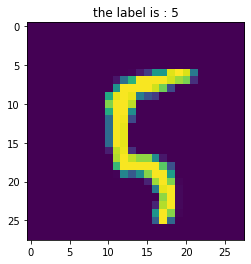

In [5]:
# 任意展示一张图片
choose_num = 100 # 指定图片编号
label = labels[choose_num]
image = images[choose_num].reshape(28,28)
plt.imshow(image)
plt.title('the label is : {}'.format(label))
plt.show()

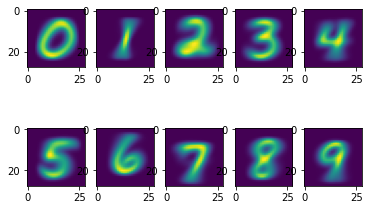

In [6]:
# 各个数字的平均图
for i in range(10):
    digit = np.mean(images[labels == i], axis = 0)
    digit = digit.reshape(28,28)
    plt.subplot(2, 5, i+1)
    plt.imshow(digit)

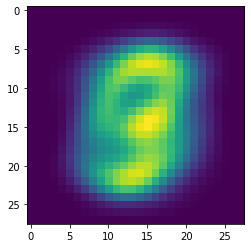

In [7]:
# 整个数据集的平均图
mean = np.mean(images, axis = 0)
mean_img = np.array(mean).reshape(28,28)
plt.imshow(mean_img)
plt.show()

# PCA分解

## 数据去中心化

In [8]:
std_images = images - mean

## 计算协方差矩阵

In [9]:
C = np.cov(std_images, rowvar=0) # rowvar=0 表示每一行代表一个样本

In [10]:
C.shape

(784, 784)

## 求特征值、特征向量

In [11]:
vals, vecs = np.linalg.eig(C) # 注意：计算得到的特征值并不是按照一定次序排列的，特征向量的每一列对应每一个特征值。
vals = vals.real
vecs = vecs.real
sorted_vals_indexes = np.argsort(-vals) # 得到特征值从大到小排列的下标

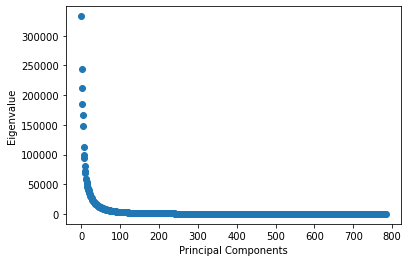

In [12]:
# 绘制特征值分布
plt.ylabel('Eigenvalue')
plt.xlabel('Principal Components')
plt.scatter(range(len(vals)),vals[sorted_vals_indexes])
plt.show()

## 降维

In [13]:
pca_dim = 2

In [14]:
def get_Z(dim):
    # 提取前2个特征向量转置构成新的标准正交基
    U = vecs[:,sorted_vals_indexes[:dim]]
    # 将中心化后的数据与特征向量做矩阵乘法得到降维后的矩阵
    Z = np.dot(std_images, U)
    return Z

In [15]:
Z = get_Z(pca_dim)
Z

array([[ -123.93258866,  -312.67426202],
       [-1011.71837587,  -294.85703827],
       [   51.84960805,   392.17315286],
       ...,
       [  178.0534496 ,   160.07821109],
       [ -130.60607208,    -5.59193642],
       [  173.43595244,   -24.71880226]])

至此，PCA降维完成，原来784维的向量已经映射到2维空间。

# 绘制降维后的数据

In [16]:
def plot_mnist_pca(X_pca, y):
    markers = 's','x','o','.',',','<','>', '^','8','*'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    # print(list(zip(target,markers)))
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1], s = 50,c = colors[idx]['color'], label = t, marker = m)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.figure()
    plt.show()

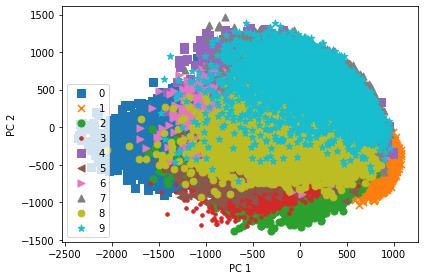

<Figure size 432x288 with 0 Axes>

In [17]:
plot_mnist_pca(Z, labels)

# 用二维特征做分类任务

In [18]:
def knn_evaluate():
    # 划分数据集
    x_train, x_test = train_test_split(Z, test_size=0.2, random_state=42)
    y_train, y_test = train_test_split(labels, test_size=0.2, random_state=42)
    # 使用KNN分类评估
    knn_clf = KNeighborsClassifier()
    knn_clf.fit(x_train, y_train)
    print(f"score: {knn_clf.score(x_test, y_test)}")

In [19]:
knn_evaluate()

score: 0.41233333333333333


# 结果分析和评估

结合图像和评估结果可知，使用PCA降维得到的二维特征做分类任务效果较差：图像上的各点重叠较多，而且评估分数仅为0.4多。这也是意料之中，因为我们可以从特征值分布图中看出，较大的特征值有多个，仅取前两个还不足以较为完整地表征数据。

为了达到更好的效果，尝试保留更多的维度，评估分类效果。

In [20]:
for dim in [2, 4, 6, 8, 10, 15, 20]:
    Z = get_Z(dim)
    print(f"dim={dim}", end='\t')
    knn_evaluate()

dim=2	score: 0.41233333333333333
dim=4	score: 0.6193333333333333
dim=6	score: 0.8255
dim=8	score: 0.9015
dim=10	score: 0.9308333333333333
dim=15	score: 0.9576666666666667
dim=20	score: 0.9695833333333334


可见，当降维到8维时，已经达到0.9的分数，那么此时提取到的主成分就能较好地表征原始数据了。